# Introduction

In this notebook we will look at some techniques for differential cell abundance analysis when you have multiple samples.

# Load packages

In [1]:
import pandas as pd
import numpy as np
import scanpy as sc

In [2]:
import matplotlib.pyplot as plt

In [4]:
import rpy2
import anndata2ri

anndata2ri.activate()
%load_ext rpy2.ipython

/var/folders/x1/3bxg2yyn42x6m5tcv9l5k511m4dgnw/T/ipykernel_8973/2909349582.py:3: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


# Load example data

In [6]:
input_path = "/Users/sharmar1/Dropbox/msk_workshop/SCALE_2024_winter/scale_2024_winter_day4/afternoon/"
adata = sc.read_h5ad(input_path + "clean_myeloid.h5ad")

In [7]:
adata

AnnData object with n_obs × n_vars = 4718 × 12786
    obs: 'Clusters', 'Celltype', 'SampleID', 'name', 'background', 'condition', 'replicate', 'experiment', 'ncells', 'libsize', 'mito_fraction', 'ribo_fraction', 'mhc_fraction', 'actin_fraction', 'cytoskeleton_fraction', 'malat1_fraction', 'scrublet_predict', 'scrublet_score', 'lowlibsize', 'Clusters_myeloid', 'Celltype_myeloid'
    obsm: 'X_pca', 'X_tsne', 'imputed_data'
    layers: 'norm_count', 'norm_log'

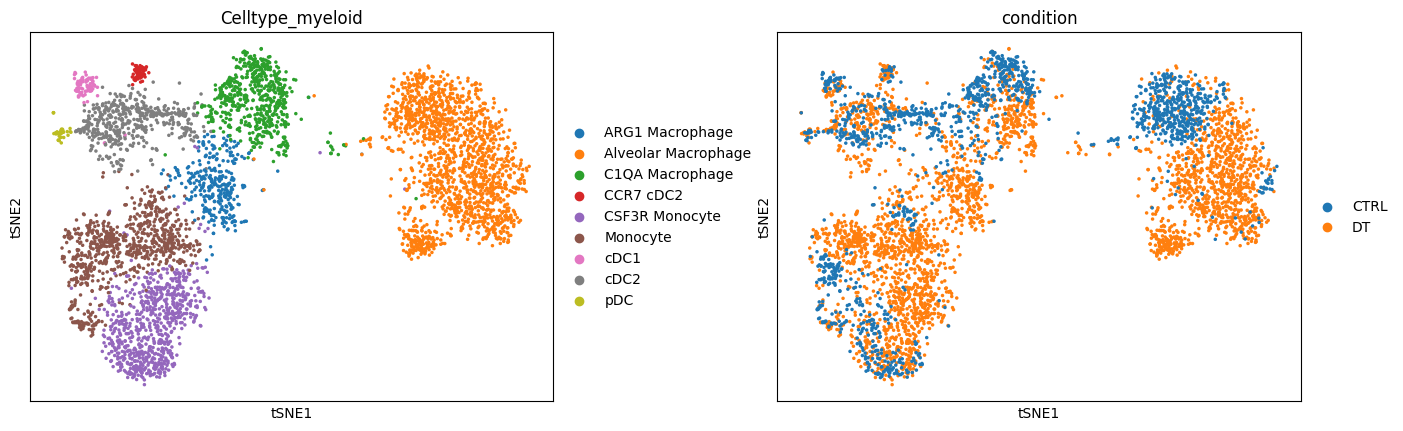

In [8]:
sc.pl.tsne(adata, color=["Celltype_myeloid", "condition"], wspace=0.3)

## Alternate visual

Let's visualize density differences based on distribution of cells on the tSNE space. This gives was a visual perspective of what the density differences look like:

In [9]:
df_temp = pd.DataFrame(
    {
        "tsne_x": adata.obsm["X_tsne"][:, 0],
        "tsne_y": adata.obsm["X_tsne"][:, 1],
        "condition": adata.obs["condition"],
    },
    index=adata.obs.index,
)

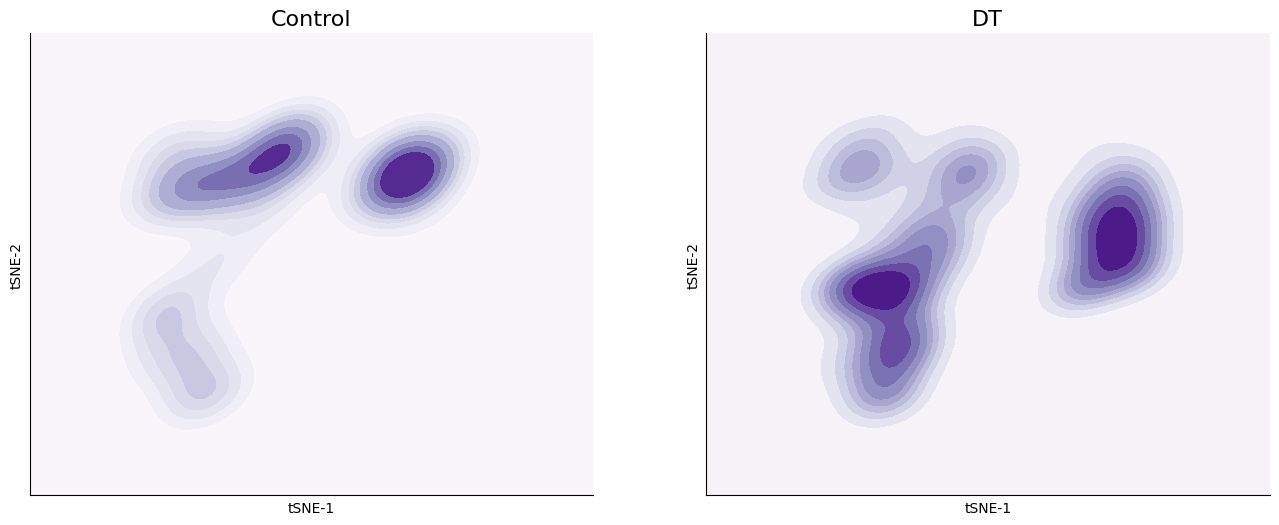

In [10]:
import seaborn as sns

fig = plt.figure(figsize=(8 * 2, 6))
ax = fig.add_subplot(1, 2, 1)
sns.scatterplot(data=df_temp, x="tsne_x", y="tsne_y", s=1, ax=ax)
sns.kdeplot(
    data=df_temp[df_temp["condition"] == "CTRL"],
    x="tsne_x",
    y="tsne_y",
    fill=True,
    thresh=0,
    levels=10,
    cmap="Purples",
    ax=ax,
    cut=4,
)
ax.set_xticks([])
ax.set_yticks([])
ax.set_title("Control", fontsize=16)
ax.set_xlabel("tSNE-1")
ax.set_ylabel("tSNE-2")
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

ax = fig.add_subplot(1, 2, 2)
sns.scatterplot(data=df_temp, x="tsne_x", y="tsne_y", s=0, ax=ax)
sns.kdeplot(
    data=df_temp[df_temp["condition"] == "DT"],
    x="tsne_x",
    y="tsne_y",
    fill=True,
    thresh=0,
    levels=10,
    cmap="Purples",
    ax=ax,
    cut=4,
)
ax.set_xticks([])
ax.set_yticks([])
ax.set_title("DT", fontsize=16)
ax.set_xlabel("tSNE-1")
ax.set_ylabel("tSNE-2")
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
# fig.savefig(outbase + 'Ctrl_DT_kdeplot_endo.png', dpi = 150, bbox_inches = 'tight')

# MiloR

Milo is a statistical method to quantify changes in cellular abundancies in neighborhoods of cells in high-dimensional space. Given a data with cells from two conditions, Milo partitions the cell phenotype space in a set of (possibly overlapping) neighborhoods and allows quantification of differential abundances of cells from one condition compared to another in each neighborhood. It outputs associated logfoldchange between the two conditions, p-values and multiple comparisons adjusted p-values for each neighborhood. Furthermore, Milo allows one to annotate each neighborhood as a distinct celltype based on the proportion of cells from each celltype in the neighborhood. All of this is discussed in the code below. 

Milo's strength lies in detecting subtle `local` changes in cellular abundances. This is possible by the use of graphs and looking for changes in occupancy locally along the graph. 

For more details, please see the original publication: https://www.nature.com/articles/s41587-021-01033-z.

We will use the R implementation from Python.

## Set up for MiloR

Create a separate anndata object for Milo for simplicity. We will need to provide log-normalized data, the condition, celltypes information. We also need to provide the computed PCA coordinates to construct the graph and tSNE coordinates to visualize.

In [11]:
adata_milo = sc.AnnData(
    adata.layers["norm_log"].copy(),
    obs=adata.obs[["SampleID", "Celltype_myeloid", "condition"]],
    var=adata.var,
)
adata_milo.obsm["X_pca"] = adata.obsm["X_pca"]
adata_milo.obsm["X_tsne"] = adata.obsm["X_tsne"]

## Run MiloR

In [12]:
%%R -i adata_milo

# load necessary R packages
library(miloR, quietly = TRUE)
library(igraph, quietly = TRUE)

# create a Milo object
myeloid_milo <- Milo(adata_milo)

# Build graph
myeloid_milo <- buildGraph(myeloid_milo, k=30, d=50, reduced.dim = "PCA")


Attaching package: ‘limma’

The following object is masked from ‘package:BiocGenerics’:

    plotMA


Attaching package: ‘edgeR’

The following object is masked from ‘package:SingleCellExperiment’:

    cpm


Attaching package: ‘igraph’

The following object is masked from ‘package:miloR’:

    graph

The following object is masked from ‘package:GenomicRanges’:

    union

The following object is masked from ‘package:IRanges’:

    union

The following object is masked from ‘package:S4Vectors’:

    union

The following objects are masked from ‘package:BiocGenerics’:

    normalize, path, union

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Constructing kNN graph with k:30


A note on the parameters for building graph:
- k = 30 indicates we build a graph for 30 nearest neighbors
- d = 50 indicates that we are using the 50 principal components provided with the data

## Construct Design Matrix

Now we set up the Design matrix. We follow the same procedure as illustrated in the Milo package example documentation (https://rawcdn.githack.com/MarioniLab/miloR/3646391023f600bae00efd9d940b888503d7a536/docs/articles/milo_demo.html). The example in this notebook does not have many covariates, so this is an example of 'vanilla' application of Milo. For more complicated scenarios, please see https://bioconductor.org/packages/release/bioc/vignettes/miloR/inst/doc/milo_contrasts.html.

In [13]:
design_df = adata_milo.obs[["condition", "SampleID"]].copy()
design_df.drop_duplicates(inplace=True)
design_df.index = design_df["SampleID"]
design_df

,condition,SampleID
SampleID,,
2_DT_1_CD45_minus,DT,2_DT_1_CD45_minus
2_DT_1_CD45plus,DT,2_DT_1_CD45plus
2_DT_2_CD45minus,DT,2_DT_2_CD45minus
2_DT_2_CD45plus,DT,2_DT_2_CD45plus
2_DT_3_CD45_minus,DT,2_DT_3_CD45_minus
2_DT_3_CD45plus,DT,2_DT_3_CD45plus
2_ctl_1_CD45minus,CTRL,2_ctl_1_CD45minus
2_ctl_1_CD45plus,CTRL,2_ctl_1_CD45plus
2_ctl_2_CD45plus,CTRL,2_ctl_2_CD45plus


## Differential analysis

Now we perform differential abundance analysis. Note on the parameters used for making neighborhoods:

`prop = 0.1`: It is the proportion of the data to randomly sample as the initial "anchor" cells. The larger the value of prop, the more the number of neighborhoods. 

`k = 30`: This is the number of nearest neighbors in the initial graph.

`d = 50`: This represents the number of principal components to use (Note: we already computed PCA and hence specify `reduced_dims = "PCA"`)

`refined = TRUE`: Implements a refined sampling schemes. 

For more details please see: https://rdrr.io/github/MarioniLab/miloR/man/makeNhoods.html

In [14]:
%%R -i design_df -o DA_results_myeloid
## Define neighbourhoods
myeloid_milo <- makeNhoods(myeloid_milo, prop = 0.1, k = 30, d=50, refined = TRUE, reduced_dims = "PCA")

## Count cells in neighbourhoods
myeloid_milo <- countCells(myeloid_milo, meta.data = data.frame(colData(myeloid_milo)), sample="SampleID")

## Calculate distances between cells in neighbourhoods for spatial FDR correction
myeloid_milo <- calcNhoodDistance(myeloid_milo, d=50, reduced.dim = "PCA")

## Test for differential abundance
DA_results_myeloid <- testNhoods(myeloid_milo, design = ~condition, design.df = design_df)

Checking valid object
Running refined sampling with reduced_dim
Checking meta.data validity
Counting cells in neighbourhoods
'as(<dgTMatrix>, "dgCMatrix")' is deprecated.
Use 'as(., "CsparseMatrix")' instead.
See help("Deprecated") and help("Matrix-deprecated").
Using TMM normalisation
Running with model contrasts
Performing spatial FDR correction with k-distance weighting


In [15]:
DA_results_myeloid.head()

,logFC,logCPM,F,PValue,FDR,Nhood,SpatialFDR
1,-2.552020,13.219991,6.435417,0.011235,0.029817,1.0,0.027766
2,-1.658053,12.510093,2.597062,0.107164,0.166538,2.0,0.160167
3,4.890283,13.233001,11.893620,0.000571,0.003861,3.0,0.003570
4,-1.172270,12.492417,1.313566,0.251838,0.337487,4.0,0.330434
5,-1.431348,12.712209,1.838476,0.175228,0.245417,5.0,0.238963


Text(0, 0.5, '- log10(Spatial FDR)')

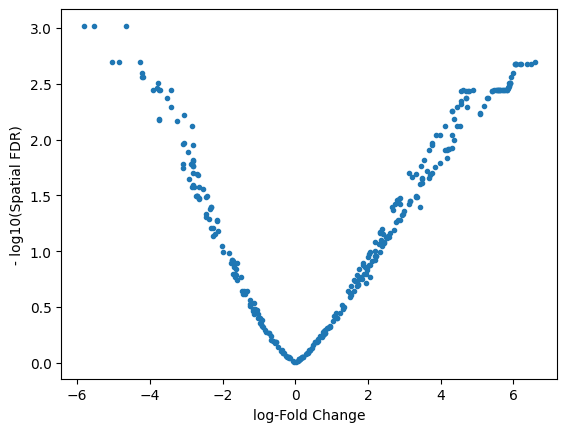

In [16]:
plt.plot(DA_results_myeloid.logFC, -np.log10(DA_results_myeloid.SpatialFDR), ".")
plt.xlabel("log-Fold Change")
plt.ylabel("- log10(Spatial FDR)")

## Visualize in R

In [17]:
%%R
myeloid_milo <- buildNhoodGraph(myeloid_milo)

In [18]:
%%R 
head(DA_results_myeloid)

      logFC   logCPM         F      PValue         FDR Nhood  SpatialFDR
1 -2.552020 13.21999  6.435417 0.011235255 0.029816638     1 0.027765546
2 -1.658053 12.51009  2.597062 0.107163663 0.166538125     2 0.160167482
3  4.890283 13.23300 11.893620 0.000570764 0.003861051     3 0.003570464
4 -1.172270 12.49242  1.313566 0.251838345 0.337487454     4 0.330434373
5 -1.431348 12.71221  1.838476 0.175228218 0.245416957     5 0.238963263
6 -2.314546 13.18328  5.503363 0.019042522 0.042939020     6 0.040358161


Please refer to the documentation for plotNhoodGraphDA for the choice of parameters: https://rdrr.io/github/MarioniLab/miloR/man/plotNhoodGraphDA.html.

In the example below:<br>
(1) We visualize the NhoodGraph for myeloid_milo <br>
(2) Color the neighborhood by 'SpatialFDR' as specified in `DA_results_myeloid` <br>
(3) alpha = alpha_val is a parameter that only includes those neighborhood that have SpatialFDR smaller than alpha_val. For below, we set it to 1, so we can look at all neighborhoods. You may want to choose a different parameter if you want to focus on only those neighborhoods that are significantly differential. <br>
(4) layout = "TSNE" specifies the low-dimensional visual to use. <br>
For aesthetics:<br>
(5) size_range specifices the range of sizes of the circles for the neighborhoods. <br>
(6) node_stroke specifies the thickness of connecting lines.

Adding nhood effect sizes to neighbourhood graph attributes


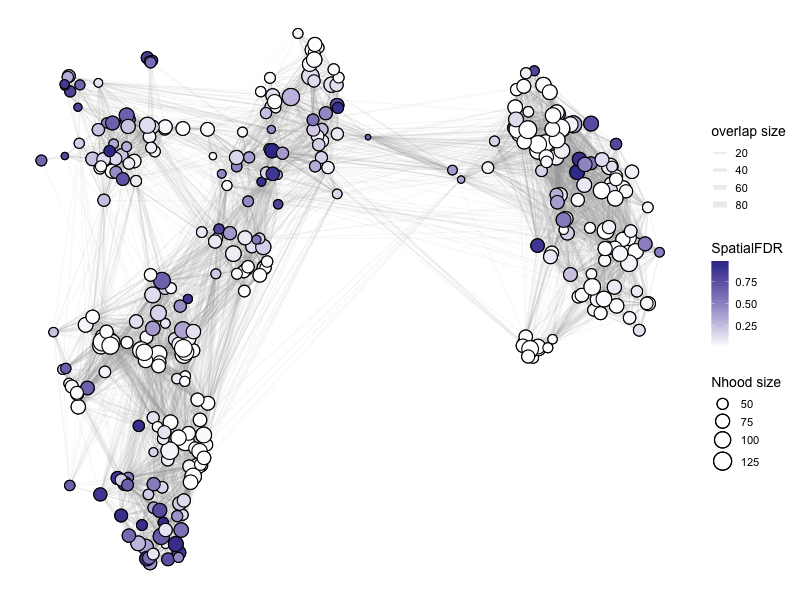

In [19]:
%%R -w 800 -h 600
# color by Spatial_FDR
alpha_val = 1
library(ggplot2)
p1 <- plotNhoodGraphDA(myeloid_milo, DA_results_myeloid, res_column = 'SpatialFDR', alpha=alpha_val, 
                 layout="TSNE", size_range = c(2, 8), node_stroke =0.8)
p1

Adding nhood effect sizes to neighbourhood graph attributes


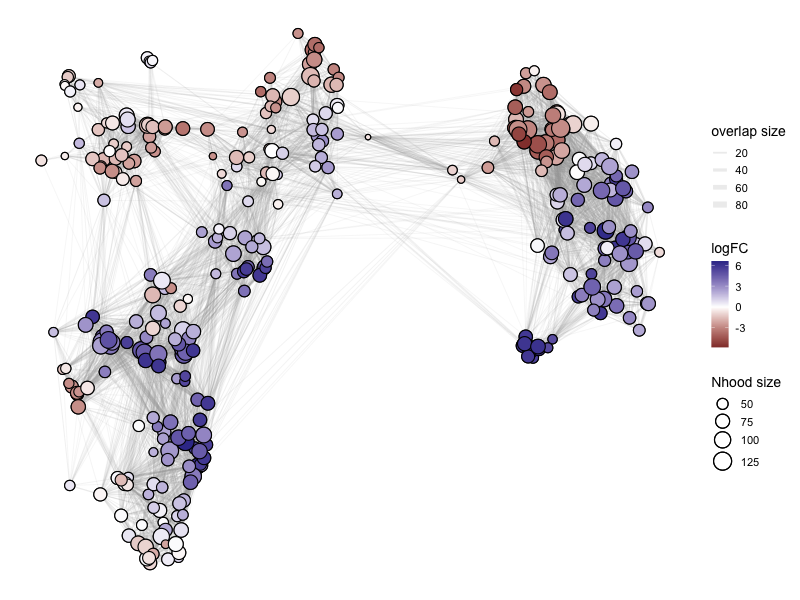

In [20]:
%%R -w 800 -h 600
# color by log fold change
alpha_val = 1
library(ggplot2)
p1 <- plotNhoodGraphDA(myeloid_milo, DA_results_myeloid, res_column = 'logFC', alpha=alpha_val, 
                 layout="TSNE", size_range = c(2, 8), node_stroke =0.8)
p1

Plot and save directly from R:

In [22]:
%%R -w 600 -h 450
library(ggplot2)
alpha_val = 1

# outbase is the path where we want to save the output
outbase = '/Users/sharmar1/Dropbox/msk_workshop/GSCN_2025/'
for (j in c('SpatialFDR', 'FDR', 'PValue', 'logFC')){
    p1 <- plotNhoodGraphDA(myeloid_milo, DA_results_myeloid, res_column = j, alpha=alpha_val, layout="TSNE", 
                           size_range = c(2, 8), node_stroke =.8)
    p1    
    ggsave(paste0(outbase, 'milor_R_myeloid_', j, '.pdf'), p1, dpi = 200)
}

Saving 8.33 x 6.25 in image
Saving 8.33 x 6.25 in image
Saving 8.33 x 6.25 in image
Saving 8.33 x 6.25 in image


Adding nhood effect sizes to neighbourhood graph attributes
Adding nhood effect sizes to neighbourhood graph attributes
Adding nhood effect sizes to neighbourhood graph attributes
Adding nhood effect sizes to neighbourhood graph attributes


## Add celltype information

Milo also allows to divide the neighborhoods based on the most representative celltype in that neighborhood.

In [23]:
%%R 
DA_results_myeloid <- annotateNhoods(myeloid_milo, DA_results_myeloid, coldata_col = "Celltype_myeloid")
head(DA_results_myeloid)

      logFC   logCPM         F      PValue         FDR Nhood  SpatialFDR
1 -2.552020 13.21999  6.435417 0.011235255 0.029816638     1 0.027765546
2 -1.658053 12.51009  2.597062 0.107163663 0.166538125     2 0.160167482
3  4.890283 13.23300 11.893620 0.000570764 0.003861051     3 0.003570464
4 -1.172270 12.49242  1.313566 0.251838345 0.337487454     4 0.330434373
5 -1.431348 12.71221  1.838476 0.175228218 0.245416957     5 0.238963263
6 -2.314546 13.18328  5.503363 0.019042522 0.042939020     6 0.040358161
     Celltype_myeloid Celltype_myeloid_fraction
1 Alveolar Macrophage                 1.0000000
2 Alveolar Macrophage                 0.9767442
3            Monocyte                 0.9906542
4                cDC2                 0.9756098
5     C1QA Macrophage                 0.9400000
6     C1QA Macrophage                 0.9875000


Visualize the cell type fraction distribution for the most representative cell type in each neighborhood:

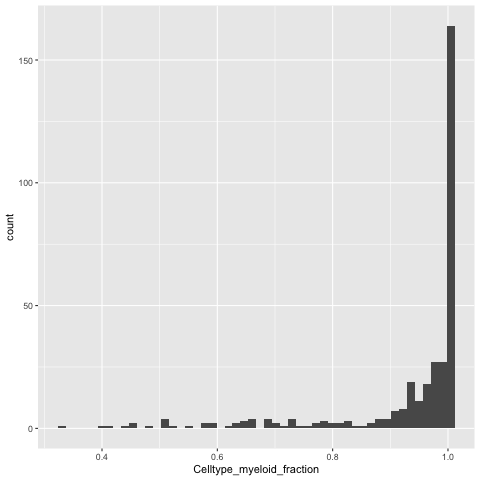

In [24]:
%%R
library(ggplot2)
ggplot(DA_results_myeloid, aes(Celltype_myeloid_fraction)) + geom_histogram(bins=50)

We can relabel the neighborhood as celltype X if 80% of the cells in the neighborhood are of X type, else we can call it "Mixed".

In [25]:
%%R -o DA_results_myeloid
DA_results_myeloid$Myeloid_Celltypes <- ifelse(DA_results_myeloid$Celltype_myeloid_fraction < 0.8, "Mixed", DA_results_myeloid$Celltype_myeloid)
head(DA_results_myeloid)

      logFC   logCPM         F      PValue         FDR Nhood  SpatialFDR
1 -2.552020 13.21999  6.435417 0.011235255 0.029816638     1 0.027765546
2 -1.658053 12.51009  2.597062 0.107163663 0.166538125     2 0.160167482
3  4.890283 13.23300 11.893620 0.000570764 0.003861051     3 0.003570464
4 -1.172270 12.49242  1.313566 0.251838345 0.337487454     4 0.330434373
5 -1.431348 12.71221  1.838476 0.175228218 0.245416957     5 0.238963263
6 -2.314546 13.18328  5.503363 0.019042522 0.042939020     6 0.040358161
     Celltype_myeloid Celltype_myeloid_fraction   Myeloid_Celltypes
1 Alveolar Macrophage                 1.0000000 Alveolar Macrophage
2 Alveolar Macrophage                 0.9767442 Alveolar Macrophage
3            Monocyte                 0.9906542            Monocyte
4                cDC2                 0.9756098                cDC2
5     C1QA Macrophage                 0.9400000     C1QA Macrophage
6     C1QA Macrophage                 0.9875000     C1QA Macrophage


Note: We have exported `DA_results_myeloid` onto Python by using `%%R -o DA_results_myeloid` above. So we can work with it in Python.

In [26]:
DA_results_myeloid.head()

,logFC,logCPM,F,PValue,FDR,Nhood,SpatialFDR,Celltype_myeloid,Celltype_myeloid_fraction,Myeloid_Celltypes
1,-2.552020,13.219991,6.435417,0.011235,0.029817,1.0,0.027766,Alveolar Macrophage,1.000000,Alveolar Macrophage
2,-1.658053,12.510093,2.597062,0.107164,0.166538,2.0,0.160167,Alveolar Macrophage,0.976744,Alveolar Macrophage
3,4.890283,13.233001,11.893620,0.000571,0.003861,3.0,0.003570,Monocyte,0.990654,Monocyte
4,-1.172270,12.492417,1.313566,0.251838,0.337487,4.0,0.330434,cDC2,0.975610,cDC2
5,-1.431348,12.712209,1.838476,0.175228,0.245417,5.0,0.238963,C1QA Macrophage,0.940000,C1QA Macrophage


## Beeswarm plot in R

Make a beeswarm plot to visualize the results. 

Note: The color code in the default version is non-sensical because it is color coded by logFoldChange which is already in the x-axis. Hence there is no colormap to quantify the color code.

Converting group_by to factor...


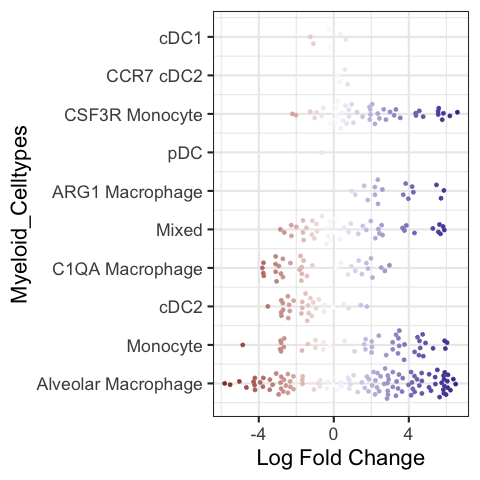

In [27]:
%%R
plotDAbeeswarm(DA_results_myeloid, group.by = "Myeloid_Celltypes", alpha = 1)

R code to change the colormap in the beeswarmplot (again non-sensical because it is quantified in the x-axis):

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


Converting group_by to factor...


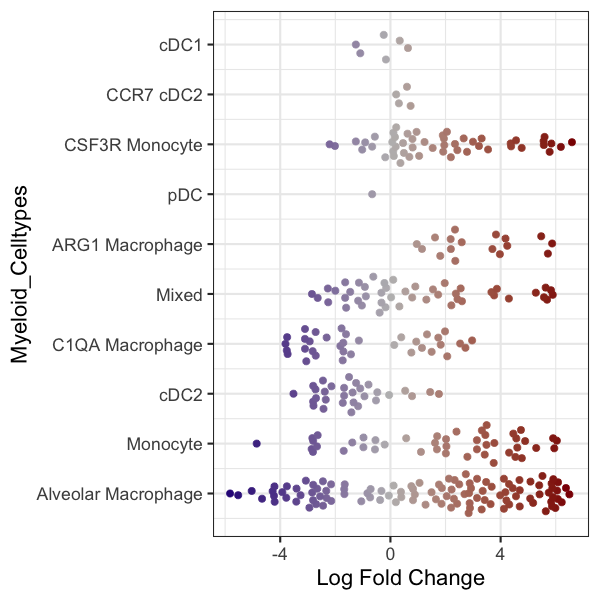

In [28]:
%%R -w 600 -h 600
library(ggplot2)
library(ggbeeswarm)
library(scales)

p1 <- plotDAbeeswarm(DA_results_myeloid, group.by = "Myeloid_Celltypes", alpha = alpha_val) 

p1 <- p1 + geom_quasirandom(size = 3) 
p1 <- p1 + scale_color_gradient2(low = "navyblue", mid = "gray74", high = "darkred", guide = "colourbar")


p1
#outbase = '/path_to_save/'
#ggsave(paste0(outbase, 'milor_R_myeloid_swarmplot.pdf'), p1, dpi = 200)

## Alternate visual

The following is a python code that loads the `DA_results_myeloid` onto Python and creates a stripplot using Seaborn package. This is a replacement for the beeswarmplot and enables additional control. For example below, we color code each neighborhood by the p-values associated with each neighborhood. So unlike the above beeswarmplot, here the color of the neighborhood is not the `logFoldChange` (which is already on the x-axis):

/var/folders/x1/3bxg2yyn42x6m5tcv9l5k511m4dgnw/T/ipykernel_8973/75971933.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cbar.ax.set_yticklabels(cbar.ax.get_yticks(), fontsize = 18)
/var/folders/x1/3bxg2yyn42x6m5tcv9l5k511m4dgnw/T/ipykernel_8973/75971933.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cbar.ax.set_yticklabels(cbar.ax.get_yticks(), fontsize = 18)
/var/folders/x1/3bxg2yyn42x6m5tcv9l5k511m4dgnw/T/ipykernel_8973/75971933.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cbar.ax.set_yticklabels(cbar.ax.get_yticks(), fontsize = 18)


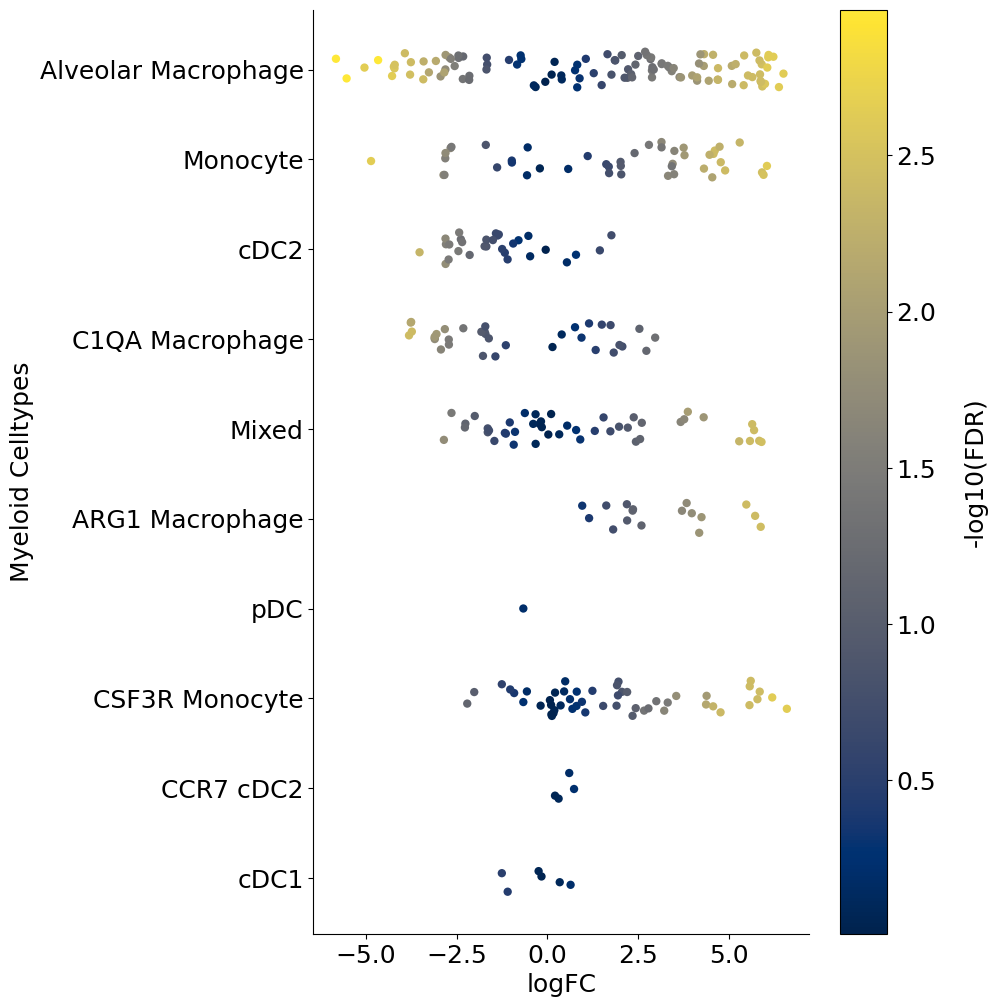

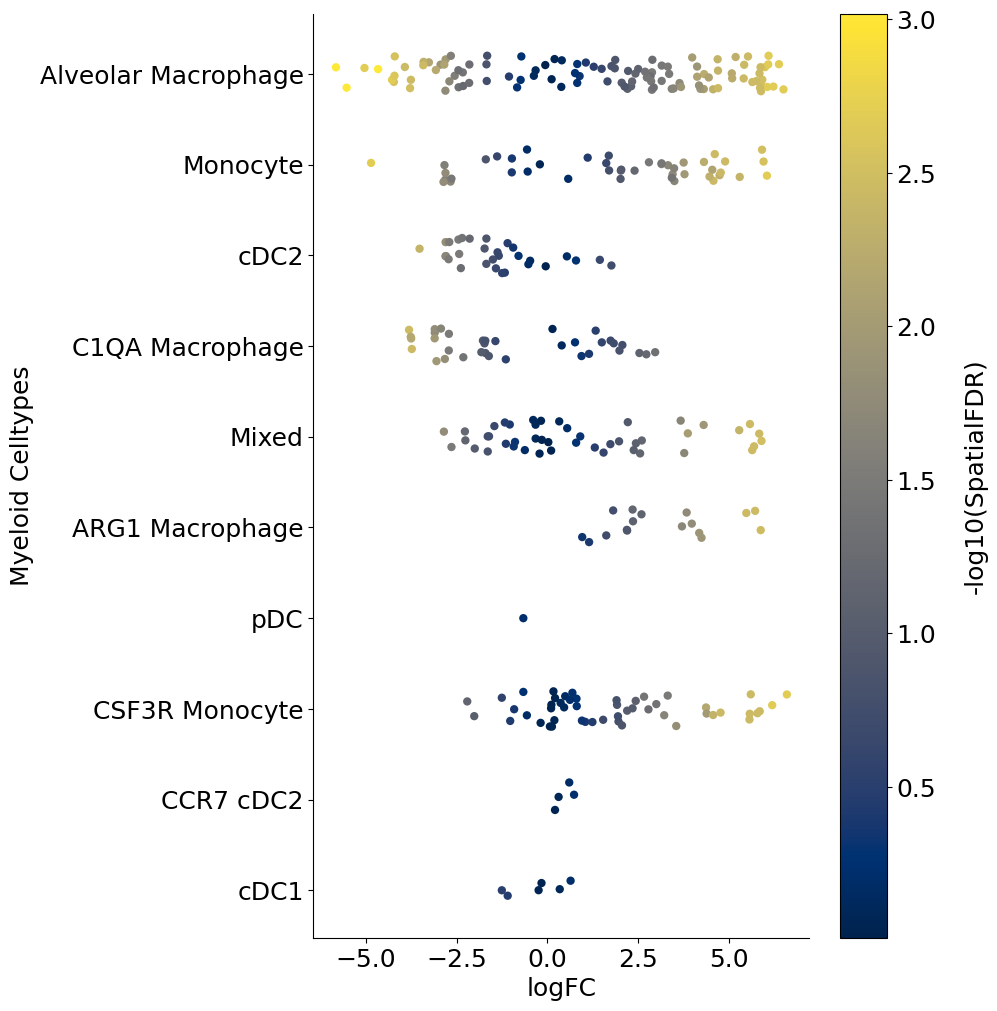

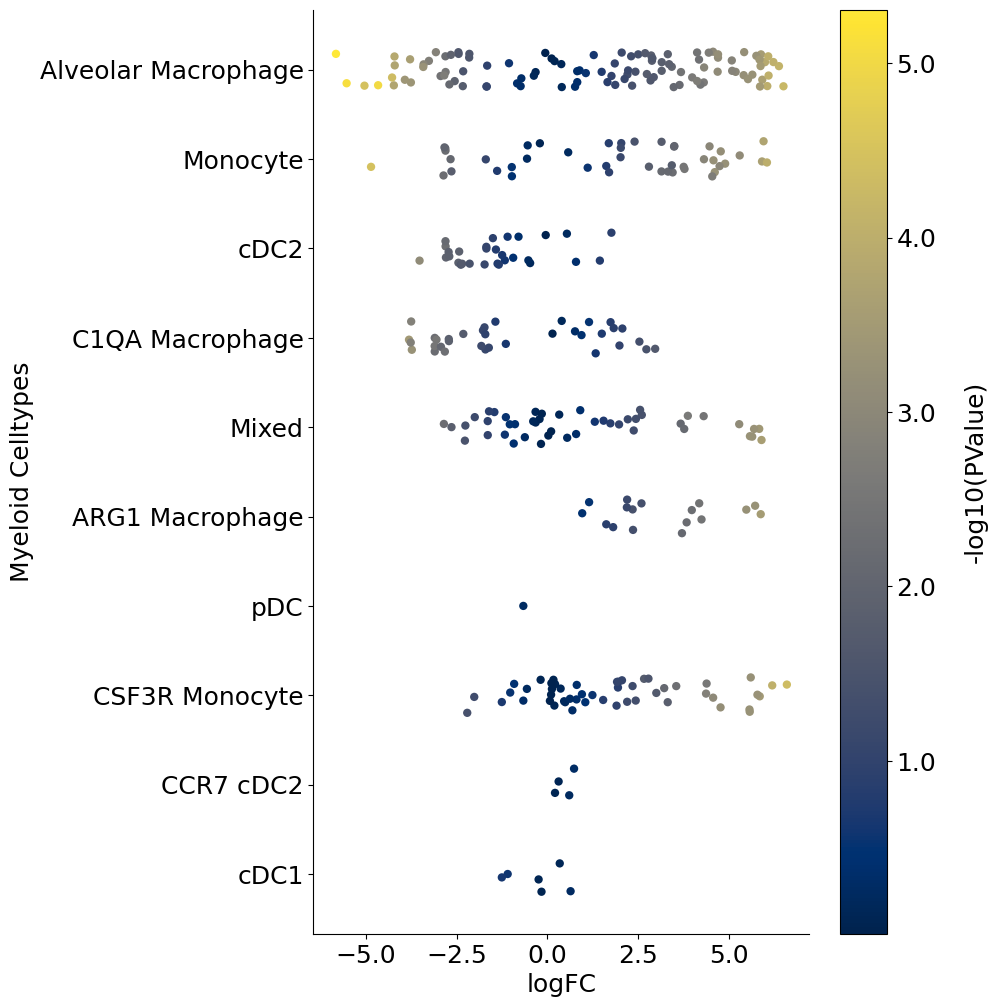

In [29]:
import matplotlib.colors as mcolors
import matplotlib.cm as cm

outbase = "/Users/sharmar1/Dropbox/msk_workshop/GSCN_2025/"

for j, item in enumerate(["FDR", "SpatialFDR", "PValue"]):
    fig = plt.figure(figsize=(8, 12))
    DA_results_myeloid["log_" + item] = -np.log10(DA_results_myeloid[item])
    ax = fig.add_subplot(1, 1, 1)
    plot = sns.stripplot(
        x="logFC",
        y="Myeloid_Celltypes",
        hue="log_" + item,
        data=DA_results_myeloid,
        size=6,
        palette="cividis",
        jitter=0.2,
        edgecolor="none",
        ax=ax,
    )
    plot.get_legend().set_visible(False)
    # ax.set_xticklabels(ax.get_xticks(), fontsize = 18)
    # ax.set_yticklabels(ax.get_yticks(), fontsize = 18)
    ax.tick_params(axis="both", which="major", labelsize=18)
    ax.set_ylabel("Myeloid Celltypes", fontsize=18)
    ax.set_xlabel("logFC", fontsize=18)
    sns.despine()

    # Drawing the side color bar
    normalize = mcolors.Normalize(
        vmin=DA_results_myeloid["log_" + item].min(),
        vmax=DA_results_myeloid["log_" + item].max(),
    )
    colormap = cm.cividis

    for n in DA_results_myeloid["log_" + item]:
        plt.plot(color=colormap(normalize(n)))

    scalarmappaple = cm.ScalarMappable(norm=normalize, cmap=colormap)
    scalarmappaple.set_array(DA_results_myeloid["log_" + item])
    cbar = fig.colorbar(scalarmappaple, ax=plt.gca())
    cbar.ax.set_yticklabels(cbar.ax.get_yticks(), fontsize=18)
    cbar.ax.set_ylabel("-log10(" + item + ")", labelpad=20, rotation=90, fontsize=18)
    ax.grid(False)
    # fig.savefig(outbase + 'milor_myeloid_swarmplot_colored_by_log_' + item + '.pdf', dpi = 300,
    #            bbox_inches = 'tight')

## Adding contrasts in Milo models

We can extend the idea of computing cellular abundance changes using Milo for more than a pair of conditions. For example, if you have data from different timepoints or conditions and wish to compute different flavors of contrasts, you can use Milo as follows. We will follow the example provided by the authors: https://bioconductor.org/packages/release/bioc/vignettes/miloR/inst/doc/milo_contrasts.html

For illustration, let's randomly assign half of control cells into one group and remaining half to another, while leaving DT as is:

In [30]:
np.unique(adata.obs[["SampleID"]])

array(['2_DT_1_CD45_minus', '2_DT_1_CD45plus', '2_DT_2_CD45minus',
       '2_DT_2_CD45plus', '2_DT_3_CD45_minus', '2_DT_3_CD45plus',
       '2_ctl_1_CD45minus', '2_ctl_1_CD45plus', '2_ctl_2_CD45plus',
       '2_ctl_3_CD45plus', 'ctl_3_CD45_minus'], dtype=object)

In [31]:
map_dictionary = {
    "2_ctl_1_CD45minus": "B",
    "2_ctl_1_CD45plus": "B",
    "2_ctl_2_CD45plus": "A",
    "2_ctl_3_CD45plus": "A",
    "ctl_3_CD45_minus": "A",
    "2_DT_1_CD45_minus": "C",
    "2_DT_1_CD45plus": "C",
    "2_DT_2_CD45minus": "C",
    "2_DT_2_CD45plus": "C",
    "2_DT_3_CD45_minus": "C",
    "2_DT_3_CD45plus": "C",
}

adata.obs["random_assignment"] = adata.obs["SampleID"].map(map_dictionary)

In [32]:
adata.obs["random_assignment"]

120703424032052000    C
120703436053422000    C
120703436147574000    C
120703455025974000    C
120703455259875000    C
                     ..
170660067981030011    A
192806964092251011    A
196527716002220011    A
232261695269612011    A
239407446735798011    A
Name: random_assignment, Length: 4718, dtype: object

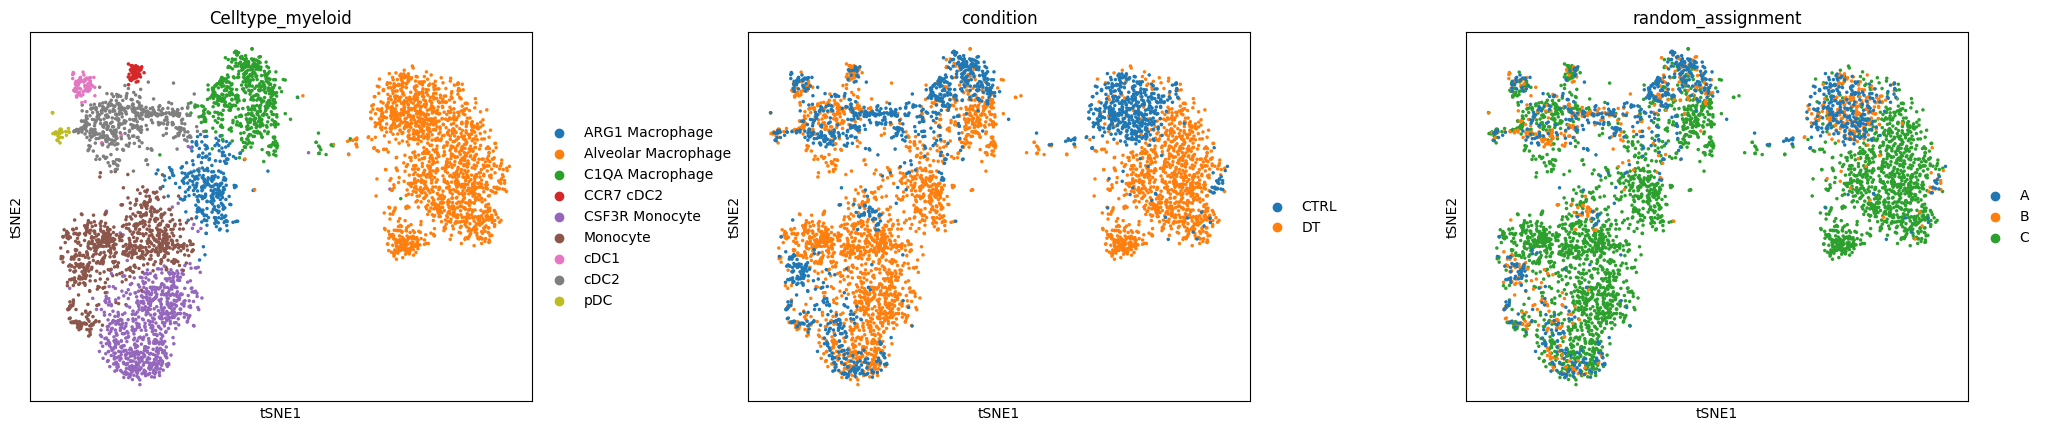

In [33]:
sc.pl.tsne(
    adata, wspace=0.3, color=["Celltype_myeloid", "condition", "random_assignment"]
)

Now let's try to build different contrasts to compare cellular abundance between the three groups A, B and C and their combinations.

In [34]:
adata_milo2 = sc.AnnData(
    adata.layers["norm_log"].copy(),
    obs=adata.obs[["SampleID", "Celltype_myeloid", "random_assignment"]],
    var=adata.var,
)
adata_milo2.obsm["X_pca"] = adata.obsm["X_pca"]
adata_milo2.obsm["X_tsne"] = adata.obsm["X_tsne"]

In [35]:
%%R -i adata_milo2
adata_milo2

class: SingleCellExperiment 
dim: 12786 4718 
metadata(0):
assays(1): X
rownames(12786): GNAI3 CDC45 ... MIR155HG IGHV5-9
rowData names(0):
colnames(4718): 120703424032052000 120703436053422000 ...
  232261695269612011 239407446735798011
colData names(3): SampleID Celltype_myeloid random_assignment
reducedDimNames(2): PCA TSNE
mainExpName: NULL
altExpNames(0):


In [36]:
%%R
# load necessary R packages
library(miloR, quietly = TRUE)
library(igraph, quietly = TRUE)

# create a Milo object
myeloid_milo2 <- Milo(adata_milo2)

# Build graph
myeloid_milo2 <- buildGraph(myeloid_milo2, k=30, d=50, reduced.dim = "PCA")

Constructing kNN graph with k:30


In [37]:
%%R
# Do all other steps that do not depend on the design matrix
# Build neighborhoods 
myeloid_milo2 <- makeNhoods(myeloid_milo2, 
                            prop = 0.1, 
                            k = 30, 
                            d=50, 
                            refined = TRUE, reduced_dims="PCA") 

## Count cells in neighbourhoods
myeloid_milo2 <- countCells(myeloid_milo2, 
                            meta.data = data.frame(colData(myeloid_milo2)), 
                            sample="SampleID")

## Calculate distances between cells in neighbourhoods for spatial FDR correction
myeloid_milo2 <- calcNhoodDistance(myeloid_milo2, d=50, reduced.dim = "PCA")

Checking valid object
Running refined sampling with reduced_dim
Checking meta.data validity
Counting cells in neighbourhoods


## Create design matrix with contrasts

In [38]:
design_df = adata_milo2.obs[["SampleID", "random_assignment"]].copy()
design_df.drop_duplicates(inplace=True)
design_df.index = design_df["SampleID"]
design_df

,SampleID,random_assignment
SampleID,,
2_DT_1_CD45_minus,2_DT_1_CD45_minus,C
2_DT_1_CD45plus,2_DT_1_CD45plus,C
2_DT_2_CD45minus,2_DT_2_CD45minus,C
2_DT_2_CD45plus,2_DT_2_CD45plus,C
2_DT_3_CD45_minus,2_DT_3_CD45_minus,C
2_DT_3_CD45plus,2_DT_3_CD45plus,C
2_ctl_1_CD45minus,2_ctl_1_CD45minus,B
2_ctl_1_CD45plus,2_ctl_1_CD45plus,B
2_ctl_2_CD45plus,2_ctl_2_CD45plus,A


In [39]:
design_df.shape

(11, 2)

### Example one: contrast A vs B

In [40]:
%%R -i design_df
contrast_1 <- c("random_assignmentA - random_assignmentB")

In [41]:
%%R
DA_results_A_B <- testNhoods(myeloid_milo2, 
                             design = ~ 0 + random_assignment, 
                             design.df = design_df, 
                             model.contrasts = contrast_1, 
                             fdr.weighting="graph-overlap")

Using TMM normalisation
Running with model contrasts
Performing spatial FDR correction with graph-overlap weighting


In [42]:
%%R
head(DA_results_A_B)

        logFC   logCPM           F    PValue FDR Nhood SpatialFDR
1  0.07272869 13.26374 0.001620185 0.9678956   1     1          1
2 -0.17166549 12.89242 0.008244692 0.9276581   1     2          1
3  0.42905205 12.64819 0.040091981 0.8413161   1     3          1
4  0.00000000 12.44544 0.000000000 1.0000000   1     4          1
5 -0.31237557 12.79881 0.029641038 0.8633203   1     5          1
6 -1.20183502 12.89538 0.276205947 0.5992426   1     6          1


In [43]:
%%R
myeloid_milo2 <- buildNhoodGraph(myeloid_milo2)

Adding nhood effect sizes to neighbourhood graph attributes


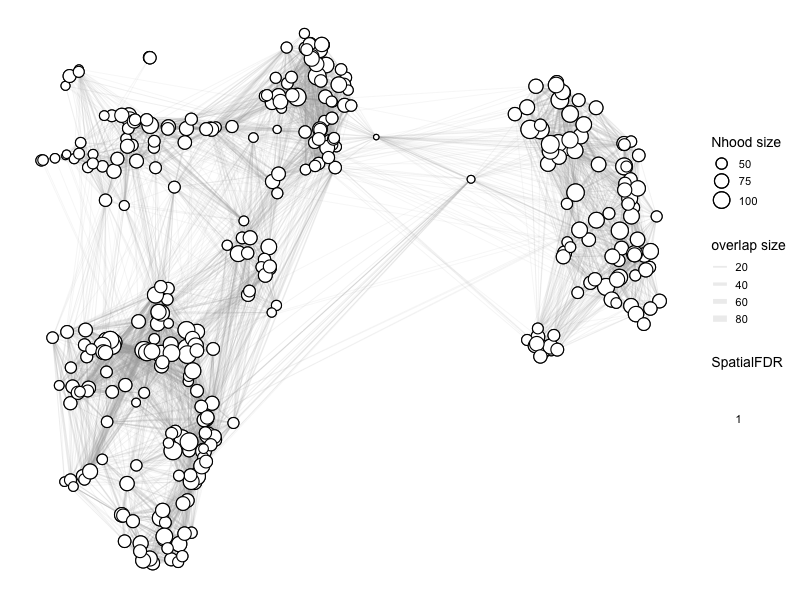

In [44]:
%%R -w 800 -h 600
# color by Spatial_FDR
alpha_val = 1
library(ggplot2)
p1 <- plotNhoodGraphDA(myeloid_milo2, 
                       DA_results_A_B, 
                       res_column = 'SpatialFDR', 
                       alpha=alpha_val, 
                       layout="TSNE", 
                       size_range = c(2, 8), 
                       node_stroke =0.8)
p1

Essentially, there is no difference anywhere as expected.

### Example two: contrast C vs (A + B)

We first design a model matrix to separate out A, B and C:

In [45]:
%%R
model <- model.matrix(~ 0 + random_assignment, data=design_df)
model

                  random_assignmentA random_assignmentB random_assignmentC
2_DT_1_CD45_minus                  0                  0                  1
2_DT_1_CD45plus                    0                  0                  1
2_DT_2_CD45minus                   0                  0                  1
2_DT_2_CD45plus                    0                  0                  1
2_DT_3_CD45_minus                  0                  0                  1
2_DT_3_CD45plus                    0                  0                  1
2_ctl_1_CD45minus                  0                  1                  0
2_ctl_1_CD45plus                   0                  1                  0
2_ctl_2_CD45plus                   1                  0                  0
2_ctl_3_CD45plus                   1                  0                  0
ctl_3_CD45_minus                   1                  0                  0
attr(,"assign")
[1] 1 1 1
attr(,"contrasts")
attr(,"contrasts")$random_assignment
[1] "contr.treatme

We can now add contrasts. Since we are looking at C vs. (A + B), we can average the effect from A and B:

In [46]:
%%R
contrast <- c("random_assignmentC - (random_assignmentA + random_assignmentB)/2")

In [47]:
%%R
# we can check the effect of dividing by 2
contrast_update <- makeContrasts(contrasts=contrast, levels=model)
contrast_update

                    Contrasts
Levels               random_assignmentC - (random_assignmentA + random_assignmentB)/2
  random_assignmentA                                                             -0.5
  random_assignmentB                                                             -0.5
  random_assignmentC                                                              1.0


In [48]:
%%R
DA_results_C_vs_AB <- testNhoods(myeloid_milo2, 
                                 design = ~ 0 + random_assignment, 
                                 design.df = design_df, 
                                 model.contrasts = contrast, 
                                 fdr.weighting="graph-overlap")

Using TMM normalisation
Running with model contrasts
Performing spatial FDR correction with graph-overlap weighting


Adding nhood effect sizes to neighbourhood graph attributes


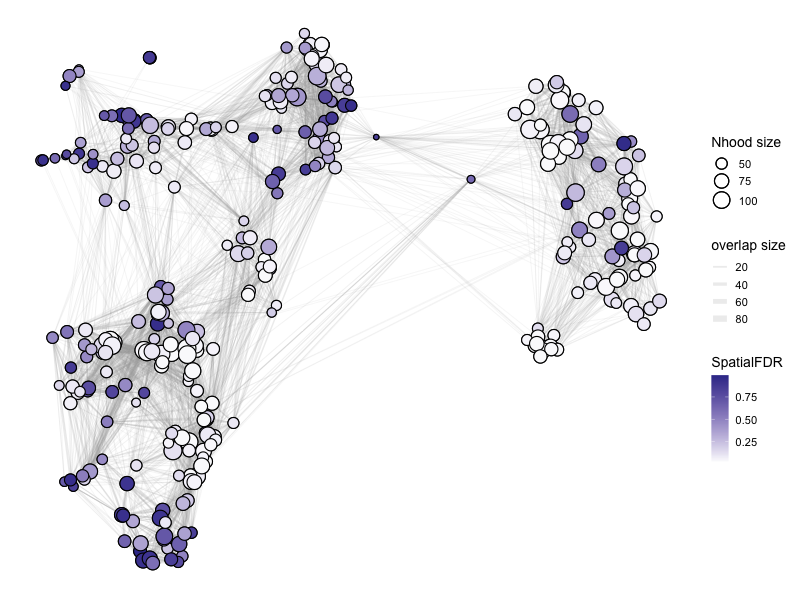

In [49]:
%%R -w 800 -h 600
# color by Spatial_FDR
alpha_val = 1
library(ggplot2)
p1 <- plotNhoodGraphDA(myeloid_milo2, 
                       DA_results_C_vs_AB, 
                       res_column = 'SpatialFDR', 
                       alpha=alpha_val, 
                       layout="TSNE", 
                       size_range = c(2, 8), 
                       node_stroke =0.8)
p1

Adding nhood effect sizes to neighbourhood graph attributes


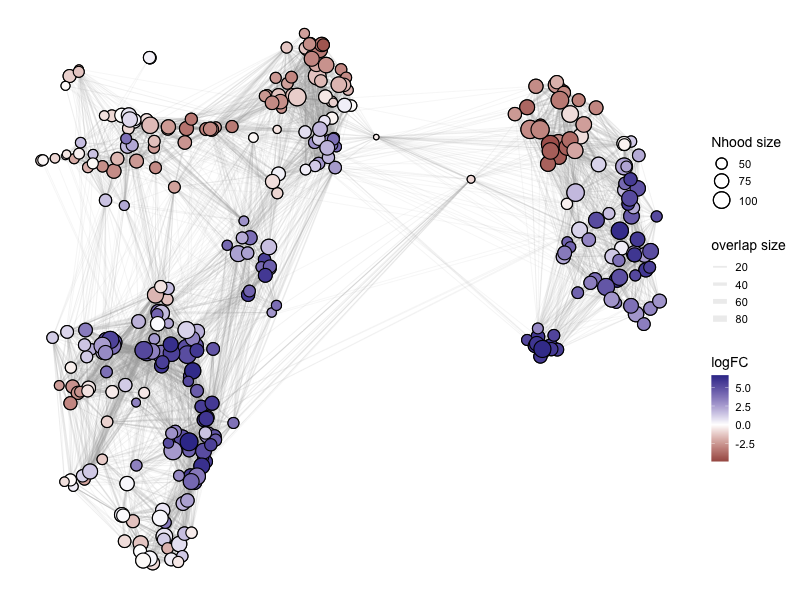

In [50]:
%%R -w 800 -h 600
# color by Spatial_FDR
alpha_val = 1
library(ggplot2)
p1 <- plotNhoodGraphDA(myeloid_milo2, 
                       DA_results_C_vs_AB, 
                       res_column = 'logFC', 
                       alpha=alpha_val, 
                       layout="TSNE", 
                       size_range = c(2, 8), 
                       node_stroke =0.8)
p1

In [51]:
%%R -o DA_results_C_vs_AB
head(DA_results_C_vs_AB)

       logFC   logCPM          F      PValue        FDR Nhood SpatialFDR
1  0.2222479 13.26374 0.03723808 0.846995833 0.88416806     1 0.90718623
2  0.3923492 12.89242 0.10061936 0.751112494 0.81207942     2 0.85542762
3  1.3130667 12.64819 0.94926343 0.329995313 0.42925172     3 0.47049823
4  5.2057702 12.44544 7.37020015 0.006674115 0.02849863     4 0.04100785
5 -0.4869355 12.79881 0.16922016 0.680838900 0.75825871     5 0.80501270
6  3.2387324 12.89538 4.51272992 0.033735366 0.07527718     6 0.08943952


You can continue with analyses similar to two condition example above.

To save your miloR results as a csv file:

In [ ]:
DA_results_myeloid.to_csv("/path_to_save/miloR_differential_abundance_output.csv")

To save your adata:

In [ ]:
adata.write_h5ad("path_to_save/processed_miloR_adata.h5ad")